In [1]:
import os
import cv2
from glob import glob

import numpy as np 
import imutils

import matplotlib.pyplot as plt
from matplotlib.image import imread 

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline



In [2]:
image_shape  = (56,64,1)
train_path = r'C:\Users\Hp\FP\Gaze Detection\Dataset Gaze\Train'
test_path  = r'C:\Users\Hp\FP\Gaze Detection\Dataset Gaze\Test'
folders=glob(test_path + '/*')
len(folders)

3

In [3]:
os.listdir(train_path)

['center', 'left', 'right']

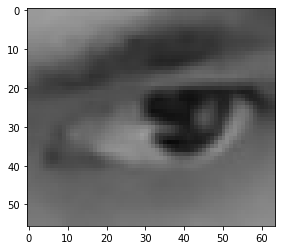

In [4]:
path = (train_path+'\\right\\'+'right_1.jpg')
img = cv2.imread(path)
plt.imshow(imutils.opencv2matplotlib(img))
plt.show()

In [5]:
traindata_gen=ImageDataGenerator(
                             rotation_range=10,
                             rescale=1/255.,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                             fill_mode='nearest'
                              )

testdata_gen=ImageDataGenerator(
                             
                             rescale=1./255)

In [6]:
traindata_gen.flow_from_directory(train_path)

Found 4800 images belonging to 3 classes.


In [7]:
model = tf.keras.Sequential([ 
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same',input_shape=image_shape, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same',input_shape=image_shape, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same',input_shape=image_shape, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), 
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5), 
        tf.keras.layers.Dense(len(folders), activation ='softmax') 
])


model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 7168)              0

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [10]:
batch_size = 32
traning_set=traindata_gen.flow_from_directory(train_path,
                                              target_size =image_shape[:2],
                                                 batch_size = batch_size,
                                                 color_mode="grayscale",
                                                 class_mode = 'categorical')

Found 4800 images belonging to 3 classes.


In [11]:
testing_set=testdata_gen.flow_from_directory(test_path,
                                            target_size = image_shape[:2],
                                                 batch_size = batch_size,
                                                 color_mode="grayscale",
                                                 class_mode = 'categorical',
                                            shuffle=False)

Found 1200 images belonging to 3 classes.


In [12]:
testing_set.class_indices

{'center': 0, 'left': 1, 'right': 2}

In [13]:
result = model.fit(
  traning_set,
  epochs=8,
  validation_data=testing_set,
  callbacks=[early_stop]
    
)

Epoch 1/8
150/150 [==============================] - 53s 355ms/step - loss: 0.5334 - accuracy: 0.7540 - val_loss: 0.0877 - val_accuracy: 0.9842
Epoch 2/8
150/150 [==============================] - 32s 216ms/step - loss: 0.1453 - accuracy: 0.9504 - val_loss: 0.0406 - val_accuracy: 0.9842
Epoch 3/8
150/150 [==============================] - 33s 219ms/step - loss: 0.0727 - accuracy: 0.9769 - val_loss: 0.0133 - val_accuracy: 0.9958
Epoch 4/8
150/150 [==============================] - 32s 214ms/step - loss: 0.0581 - accuracy: 0.9829 - val_loss: 0.0095 - val_accuracy: 0.9983
Epoch 5/8
150/150 [==============================] - 32s 216ms/step - loss: 0.0411 - accuracy: 0.9881 - val_loss: 0.0082 - val_accuracy: 0.9975
Epoch 6/8
150/150 [==============================] - 32s 213ms/step - loss: 0.0416 - accuracy: 0.9892 - val_loss: 0.0083 - val_accuracy: 0.9967
Epoch 7/8
150/150 [==============================] - 34s 225ms/step - loss: 0.0293 - accuracy: 0.9912 - val_loss: 0.1081 - val_accuracy:

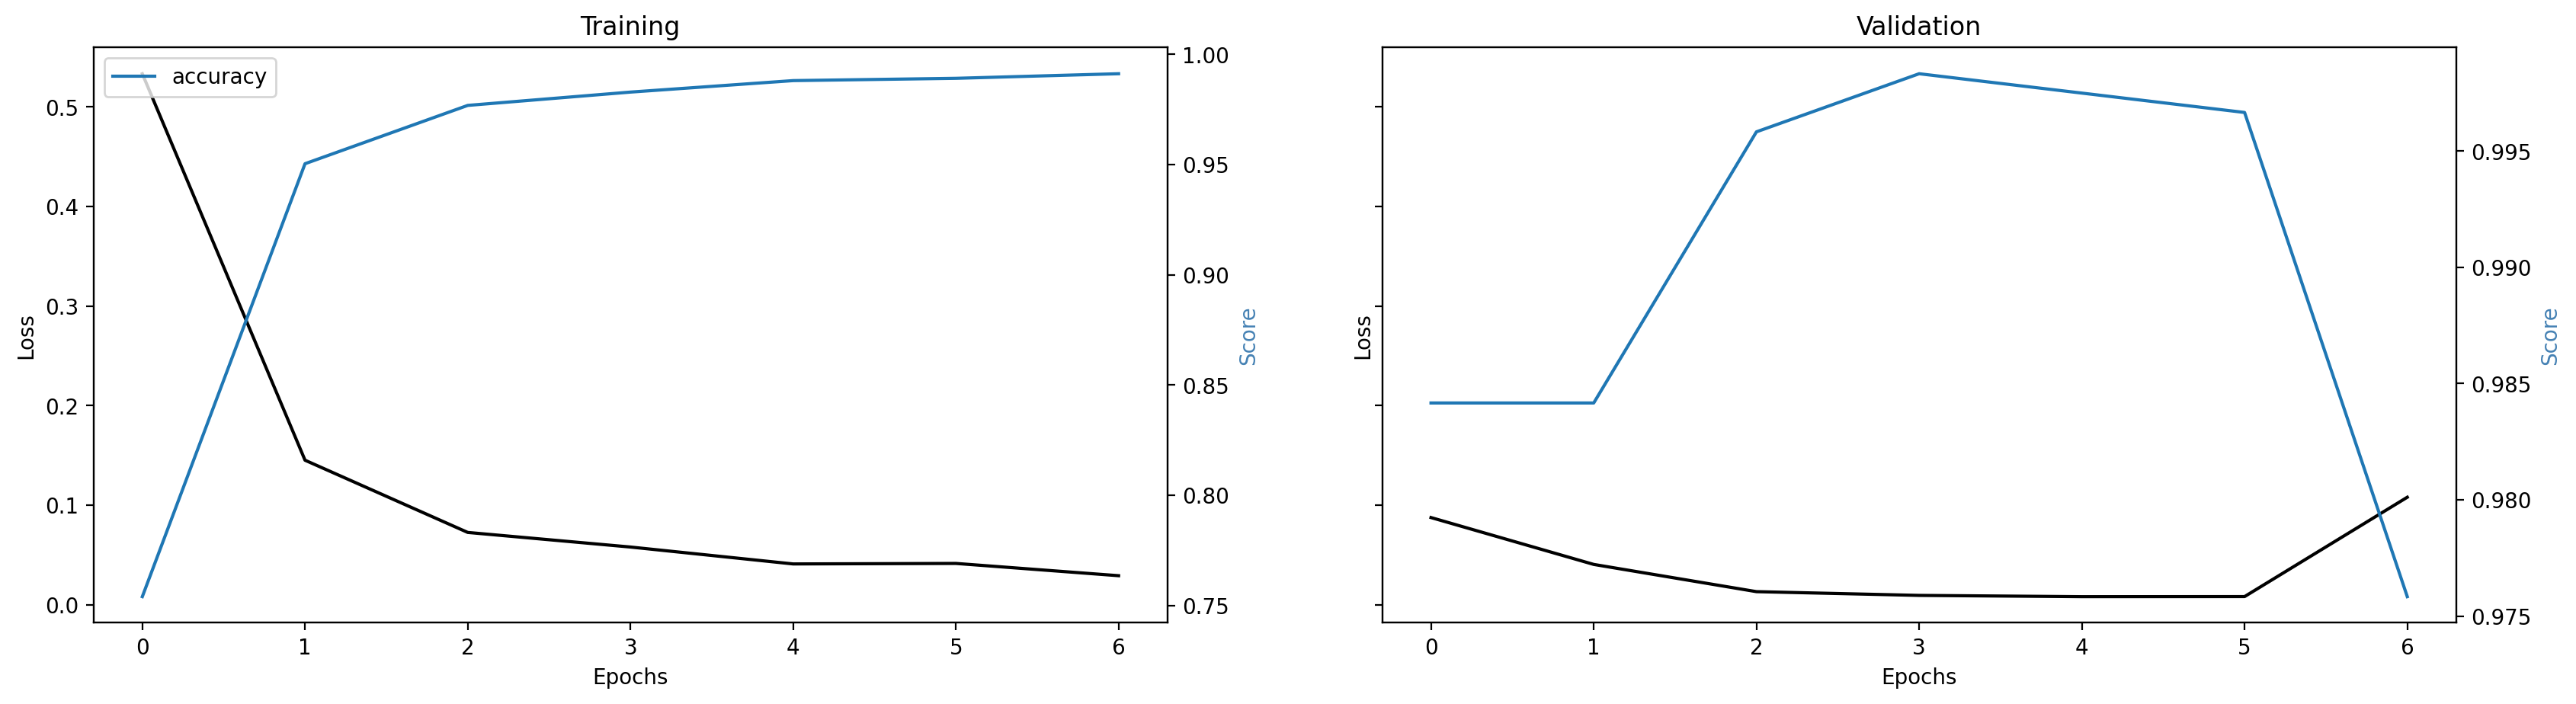

In [14]:
metrics = [k for k in result.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True , figsize=(20,5) , dpi = 200)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(result.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(result.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(result.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(result.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [15]:
model.save('gaze_model.h5')